## Test의 speaker 별 utterance length 길이 분포를 찾아 Train과 Dev에도 맞춰주기 위한 분포 분석

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from transformers import AutoTokenizer
import re
from collections import defaultdict, OrderedDict

In [2]:
def make_dataframe(path: str) -> pd.DataFrame:
    """
    Read a json file and return a pandas DataFrame.

    Parameters:
    path (str): Path to the json file.

    Returns:
    pd.DataFrame: DataFrame of the json file.
    """
    # Read the json file
    with open(path, 'r') as file:
        data = json.load(file)

    # Create a DataFrame
    # columns = ['id', 'conversation', 'subject_keyword', 'output']
    df = pd.DataFrame(data)
    df['conversation'] = df['input'].apply(lambda x: x['conversation'])
    df['subject_keyword'] = df['input'].apply(lambda x: x['subject_keyword'])

    # Drop the 'input' column
    df.drop('input', axis=1, inplace=True)

    # Speakers in the conversation
    def find_ordered_speakers(turns):
        speakers = OrderedDict()
        for turn in turns:
            speakers[turn['speaker']] = 0
        return list(speakers.keys())
    
    df['speakers'] = df['conversation'].apply(find_ordered_speakers)

    # Reorder the columns
    df = df[['id', 'conversation', 'subject_keyword', 'speakers', 'output']]

    return df

In [3]:
train_df = make_dataframe('../resource/data/일상대화요약_train.json')
dev_df = make_dataframe('../resource/data/일상대화요약_dev.json')
test_df = make_dataframe('../resource/data/일상대화요약_test.json')
filtered_train_df = make_dataframe('./train.json')
filtered_dev_df = make_dataframe('./dev.json')
filtered_test_df = make_dataframe('./test.json')

def make_utterance_analysis_dataframe(df:pd.DataFrame) -> pd.DataFrame:
    """
    Make a DataFrame for the analysis of utterances.

    Parameters:
    df (pd.DataFrame): DataFrame of the conversations.

    Returns:
    pd.DataFrame: DataFrame for the analysis of utterances.
    """
    df = deepcopy(df)

    def get_num_utterances_per_speaker(df: pd.DataFrame):
        """
        Get the number of utterances per speaker in the DataFrame.

        Parameters:
        df (pd.DataFrame): DataFrame of the data.
        """
        df = deepcopy(df)

        # Get the number of utterances per speaker
        def return_num_utterances_per_speaker(turns):
            speakers = [turn['speaker'] for turn in turns]
            if speakers is None:
                print("errror")
            return pd.Series(speakers).value_counts().to_dict()
        
        df['num_utterances_per_speaker'] = df['conversation'].apply(return_num_utterances_per_speaker)
        
        return df
    
    # Get the first speaker in the conversation
    # df['first_speaker'] = df['conversation'].apply(lambda x: x[0]['speaker'])

    # Get the number of utterances per speaker
    df = get_num_utterances_per_speaker(df)

    return df

In [4]:
train_df = make_utterance_analysis_dataframe(filtered_train_df)
dev_df = make_utterance_analysis_dataframe(filtered_dev_df)
test_df = make_utterance_analysis_dataframe(filtered_test_df)

## 첫 번재 speaker utterance 개수 - 두 번째 speaker utterance 개수 분포

In [12]:
def visualize_two_speaker_utterances_num(df:pd.DataFrame):
    """
    Visualize the number of utterances per speaker in the conversations.
    """
    df = deepcopy(df)

    # Get the number of utterances of two speakers
    speaker_1_utterances_num = df.apply(lambda x: x['num_utterances_per_speaker'].get(x['speakers'][0], 0), axis=1)
    speaker_2_utterances_num = df.apply(lambda x: x['num_utterances_per_speaker'].get(x['speakers'][1], 0), axis=1)
    
    # Color the data points with more than 50 utterances
    colors = ['blue' if x < 50 else 'red' for x in speaker_1_utterances_num]

    # Find max sample and min sample
    max_sample = df.loc[speaker_1_utterances_num.idxmax()]
    min_sample = df.loc[speaker_1_utterances_num.idxmin()]

    # Create a DataFrame
    df = pd.DataFrame({'speaker_1': speaker_1_utterances_num, 'speaker_2': speaker_2_utterances_num})

    # Plot the number of utterances of two speakers
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=df, x='speaker_1', y='speaker_2', alpha=0.5, color=colors)
    plt.xlim(0,90)
    plt.ylim(0,90)

    sns.despine()
    plt.title('Number of Utterances of Two Speakers')
    plt.xlabel('Number of Utterances of Speaker 1')
    plt.ylabel('Number of Utterances of Speaker 2')

    plt.annotate(f"max_sample ({max_sample['num_utterances_per_speaker'][max_sample['speakers'][0]]},{max_sample['num_utterances_per_speaker'][max_sample['speakers'][1]]})", 
                 (df['speaker_1'].max(), df['speaker_2'].max()), 
                 textcoords="offset points", 
                 xytext=(0,-30), ha='center', fontsize=12, color='red')
    plt.annotate(f"min_sample ({min_sample['num_utterances_per_speaker'][min_sample['speakers'][0]]},{min_sample['num_utterances_per_speaker'][min_sample['speakers'][1]]})",
                (df['speaker_1'].min(), df['speaker_2'].min()), 
                textcoords="offset points", 
                xytext=(0,-30), ha='center', fontsize=12, color='red')
    plt.show()

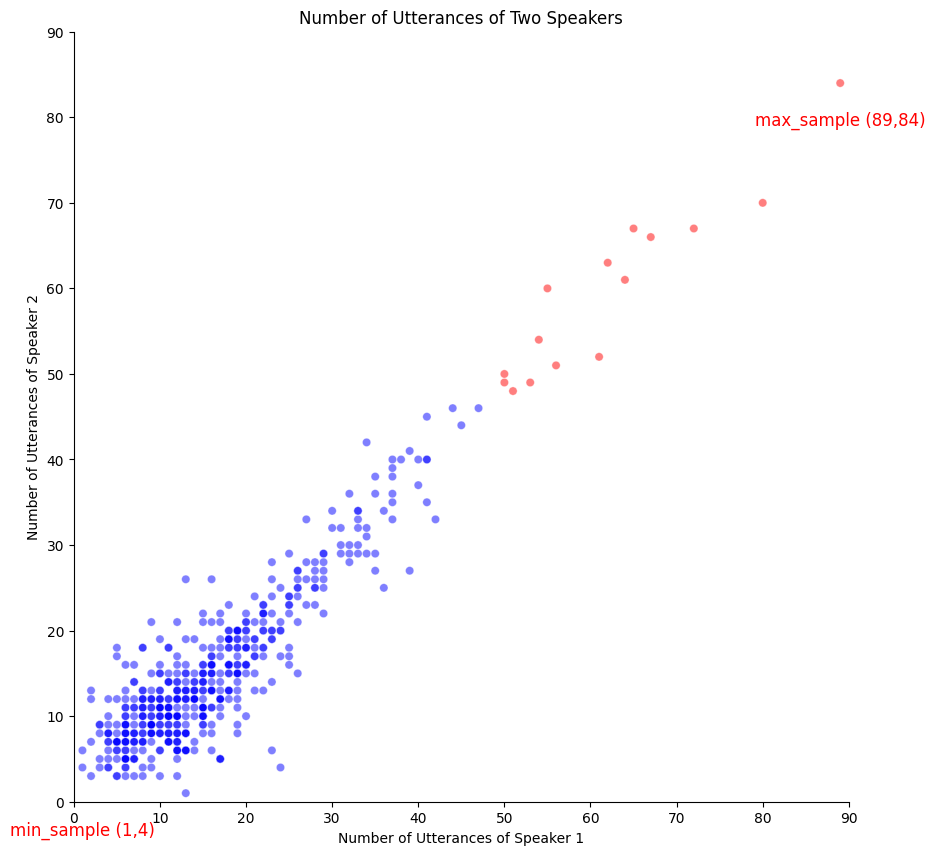

In [13]:
visualize_two_speaker_utterances_num(train_df)

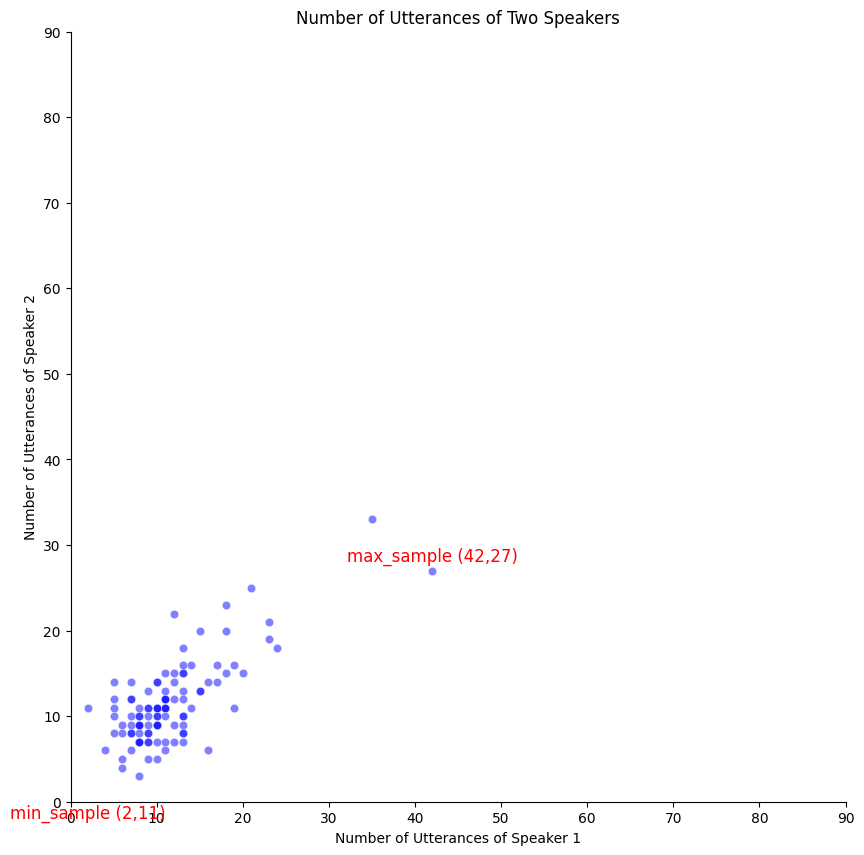

In [8]:
visualize_two_speaker_utterances_num(dev_df)

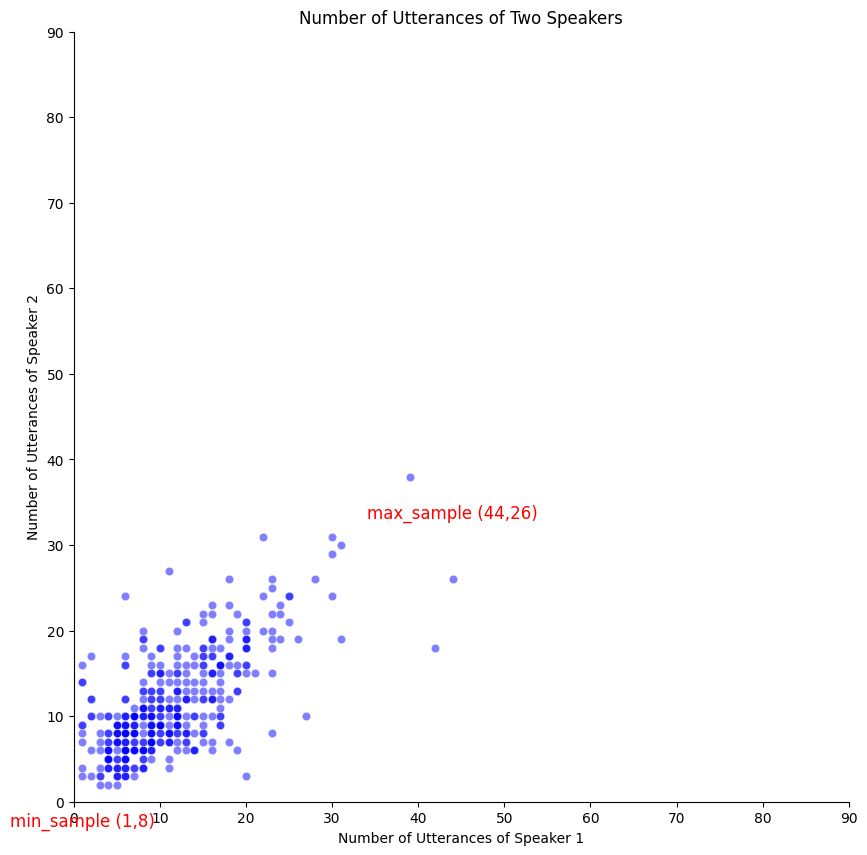

In [9]:
visualize_two_speaker_utterances_num(test_df)

In [16]:
# Visualize the length of utterances per speaker
def visualize_two_speaker_utterances_length(df:pd.DataFrame):
    """
    Visualize the length of utterances per speaker in the conversations.

    Parameters:
    df (pd.DataFrame): DataFrame of the conversations.
    """

    df = deepcopy(df)

    # Get the length of utterances of two speakers
    speaker_1_utterances_length = df.apply(lambda x: sum([len(turn['utterance']) for turn in x['conversation'] if turn['speaker'] == x['speakers'][0]]), axis=1)
    speaker_2_utterances_length = df.apply(lambda x: sum([len(turn['utterance']) for turn in x['conversation'] if turn['speaker'] == x['speakers'][1]]), axis=1)

    # Color the data points with more than 50 utterances
    speaker_1_utterances_num = df.apply(lambda x: x['num_utterances_per_speaker'].get(x['speakers'][0], 0), axis=1)
    colors = ['blue' if x < 50 else 'red' for x in speaker_1_utterances_num]

    # Find max sample and min sample
    max_sample_1 = speaker_1_utterances_length.loc[speaker_1_utterances_length.idxmax()]
    max_sample_2 = speaker_2_utterances_length.loc[speaker_2_utterances_length.idxmax()]
    min_sample_1 = speaker_1_utterances_length.loc[speaker_1_utterances_length.idxmin()]
    min_sample_2 = speaker_2_utterances_length.loc[speaker_2_utterances_length.idxmin()]

    # Create a DataFrame
    df = pd.DataFrame({'speaker_1': speaker_1_utterances_length, 'speaker_2': speaker_2_utterances_length})

    # Plot the length of utterances of two speakers
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='speaker_1', y='speaker_2', alpha=0.5, color=colors)
    plt.xlim(0, 3500)
    plt.ylim(0, 4200)

    sns.despine()
    plt.title('Length of Utterances of Two Speakers')
    plt.xlabel('Length of Utterances of Speaker 1')
    plt.ylabel('Length of Utterances of Speaker 2')
    
    plt.annotate(f"max_sample ({max_sample_1},{max_sample_2})",
                    (df['speaker_1'].max(), df['speaker_2'].max()), 
                    textcoords="offset points", 
                    xytext=(0,-30), ha='center', fontsize=12, color='red')
    plt.annotate(f"min_sample ({min_sample_1},{min_sample_2})",
                    (df['speaker_1'].min(), df['speaker_2'].min()), 
                    textcoords="offset points", 
                    xytext=(0,-30), ha='center', fontsize=12, color='red')
    
    plt.show()

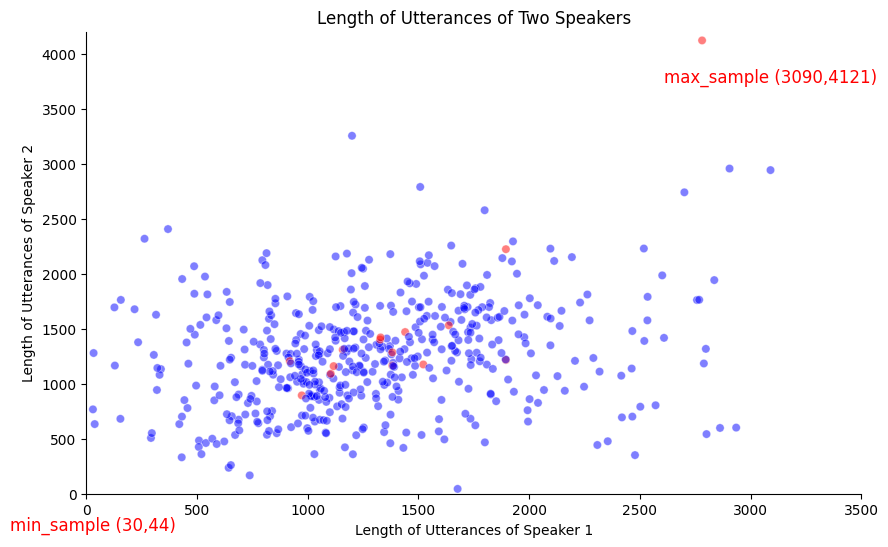

In [17]:
visualize_two_speaker_utterances_length(train_df)

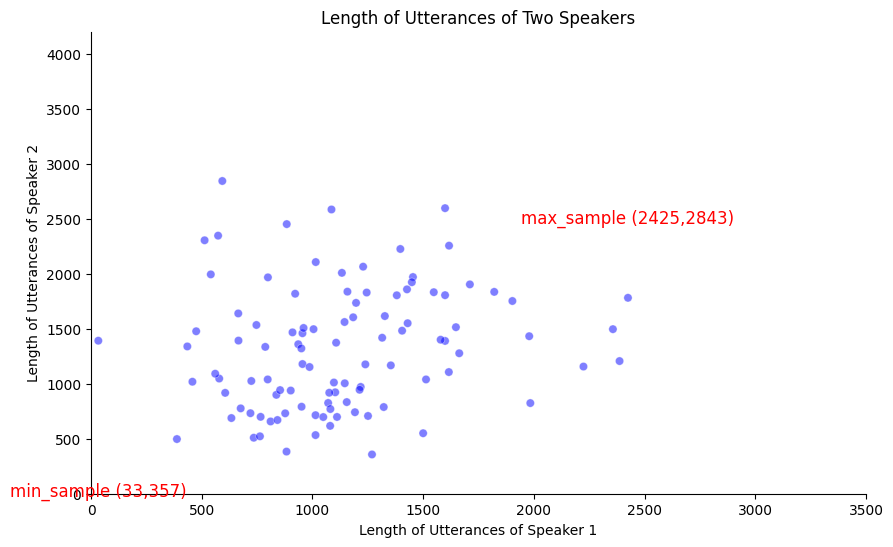

In [18]:
visualize_two_speaker_utterances_length(dev_df)

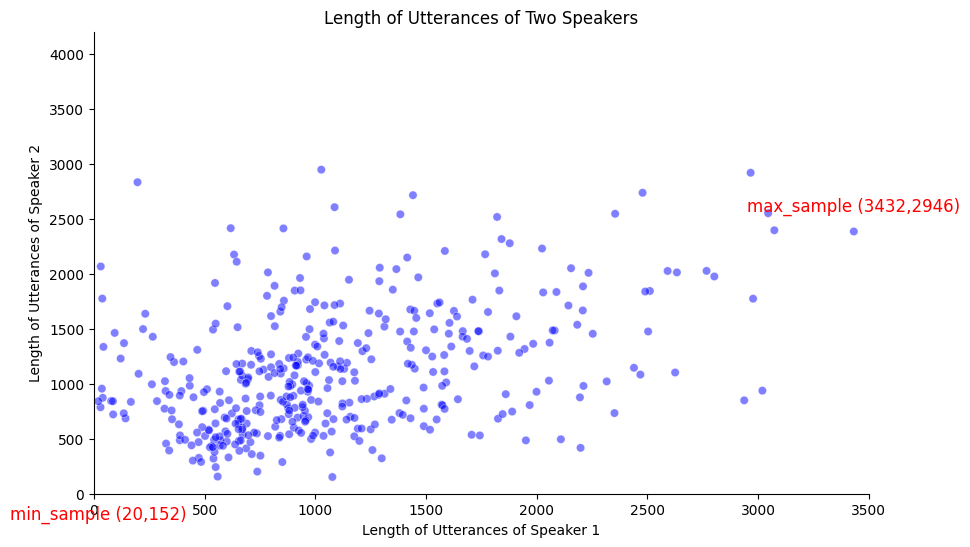

In [19]:
visualize_two_speaker_utterances_length(test_df)

## test데이터가 짧은 것도 짧은 것이지만, 전체 길이는 비슷한데, utterance의 개수는 심하게 부족한 것이 보임
    - test 데이터의 utterance는 긴 경우가 많은 것인가? 아님 train 데이터의 전체 utterance가 긴 것인가?

### 1. the average length of utterances per speaker in the conversations.

In [20]:
def visualize_two_speaker_utterances_average_length(df:pd.DataFrame):
    """
    Visualize the average length of utterances per speaker in the conversations.
    """

    df = deepcopy(df)

    # Get the average length of utterances of two speakers
    speaker_1_utterances_length = df.apply(lambda x: sum([len(turn['utterance']) for turn in x['conversation'] if turn['speaker'] == x['speakers'][0]]) / x['num_utterances_per_speaker'].get(x['speakers'][0], 1), axis=1)
    speaker_2_utterances_length = df.apply(lambda x: sum([len(turn['utterance']) for turn in x['conversation'] if turn['speaker'] == x['speakers'][1]]) / x['num_utterances_per_speaker'].get(x['speakers'][1], 1), axis=1)

    # Color the data points with more than 50 utterances
    speaker_1_utterances_num = df.apply(lambda x: x['num_utterances_per_speaker'].get(x['speakers'][0], 0), axis=1)
    colors = ['blue' if x < 50 else 'red' for x in speaker_1_utterances_num]

    # Find max sample and min sample
    max_sample_1 = speaker_1_utterances_length.loc[speaker_1_utterances_length.idxmax()]
    max_sample_2 = speaker_2_utterances_length.loc[speaker_2_utterances_length.idxmax()]
    min_sample_1 = speaker_1_utterances_length.loc[speaker_1_utterances_length.idxmin()]
    min_sample_2 = speaker_2_utterances_length.loc[speaker_2_utterances_length.idxmin()]


    # Create a DataFrame
    df = pd.DataFrame({'speaker_1': speaker_1_utterances_length, 'speaker_2': speaker_2_utterances_length})

    # Plot the average length of utterances of two speakers 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='speaker_1', y='speaker_2', alpha=0.5, color=colors)
    plt.xlim(0, 500)
    plt.ylim(0, 500)
    
    sns.despine()
    plt.title('Average Length of Utterances of Two Speakers')
    plt.xlabel('Average Length of Utterances of Speaker 1')
    plt.ylabel('Average Length of Utterances of Speaker 2')

    plt.annotate(f"max_sample ({max_sample_1:.2f},{max_sample_2:.2f})",
                    (df['speaker_1'].max(), df['speaker_2'].max()), 
                    textcoords="offset points", 
                    xytext=(0,-30), ha='center', fontsize=12, color='red')
    plt.annotate(f"min_sample ({min_sample_1:.2f},{min_sample_2:.2f})",
                    (df['speaker_1'].min(), df['speaker_2'].min()), 
                    textcoords="offset points", 
                    xytext=(0,-30), ha='center', fontsize=12, color='red')
    
    plt.show()

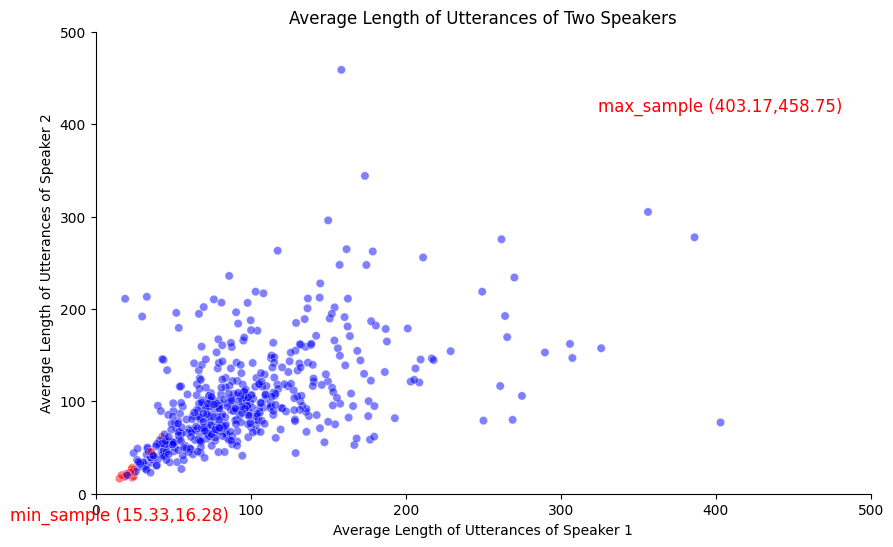

In [21]:
visualize_two_speaker_utterances_average_length(train_df)

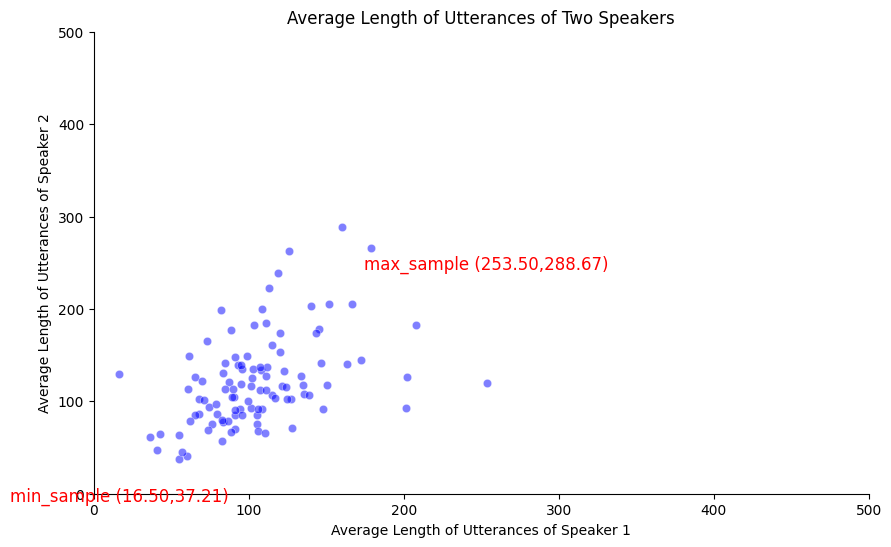

In [27]:
visualize_two_speaker_utterances_average_length(dev_df)

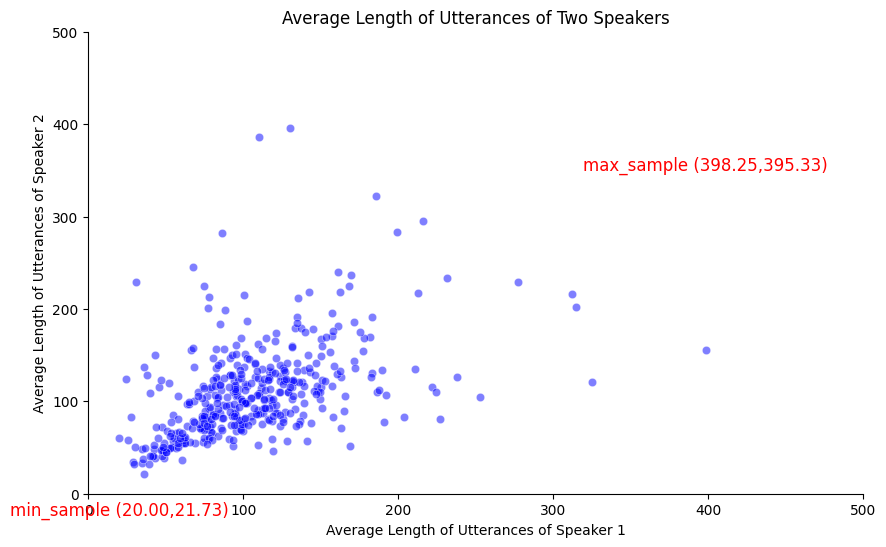

In [28]:
visualize_two_speaker_utterances_average_length(test_df)

### 2. the max length of utterances per speaker in the conversations.

In [22]:
# Visualize the max length of utterances per speaker in the conversations.

def visualize_two_speaker_utterances_max_length(df : pd.DataFrame):
    """
    Visualize the max length of utterances per speaker in the conversations.
    """

    df = deepcopy(df)

    # Get the max length of utterances of two speakers
    speaker_1_utterances_length = df.apply(lambda x: max([len(turn['utterance']) for turn in x['conversation'] if turn['speaker'] == x['speakers'][0]]), axis=1)
    speaker_2_utterances_length = df.apply(lambda x: max([len(turn['utterance']) for turn in x['conversation'] if turn['speaker'] == x['speakers'][1]]), axis=1)

    # Color the data points with more than 50 utterances
    speaker_1_utterances_num = df.apply(lambda x: x['num_utterances_per_speaker'].get(x['speakers'][0], 0), axis=1)
    colors = ['blue' if x < 50 else 'red' for x in speaker_1_utterances_num]

    # Find max sample and min sample
    max_sample_1 = speaker_1_utterances_length.loc[speaker_1_utterances_length.idxmax()]
    max_sample_2 = speaker_2_utterances_length.loc[speaker_2_utterances_length.idxmax()]
    min_sample_1 = speaker_1_utterances_length.loc[speaker_1_utterances_length.idxmin()]
    min_sample_2 = speaker_2_utterances_length.loc[speaker_2_utterances_length.idxmin()]

    # Create a DataFrame
    df = pd.DataFrame({'speaker_1': speaker_1_utterances_length, 'speaker_2': speaker_2_utterances_length})

    # Plot the max length of utterances of two speakers
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='speaker_1', y='speaker_2', alpha=0.5, color=colors) # when train
    # plt.xlim(0, 500)
    # plt.ylim(0, 500)

    sns.despine()

    plt.title('Max Length of Utterances of Two Speakers')
    plt.xlabel('Max Length of Utterances of Speaker 1')
    plt.ylabel('Max Length of Utterances of Speaker 2')
    
    plt.annotate(f"max_sample ({max_sample_1:.2f},{max_sample_2:.2f})",
                    (df['speaker_1'].max(), df['speaker_2'].max()), 
                    textcoords="offset points", 
                    xytext=(0,-30), ha='center', fontsize=12, color='red')
    plt.annotate(f"min_sample ({min_sample_1:.2f},{min_sample_2:.2f})",
                    (df['speaker_1'].min(), df['speaker_2'].min()), 
                    textcoords="offset points", 
                    xytext=(0,-30), ha='center', fontsize=12, color='red')
    
    plt.show()

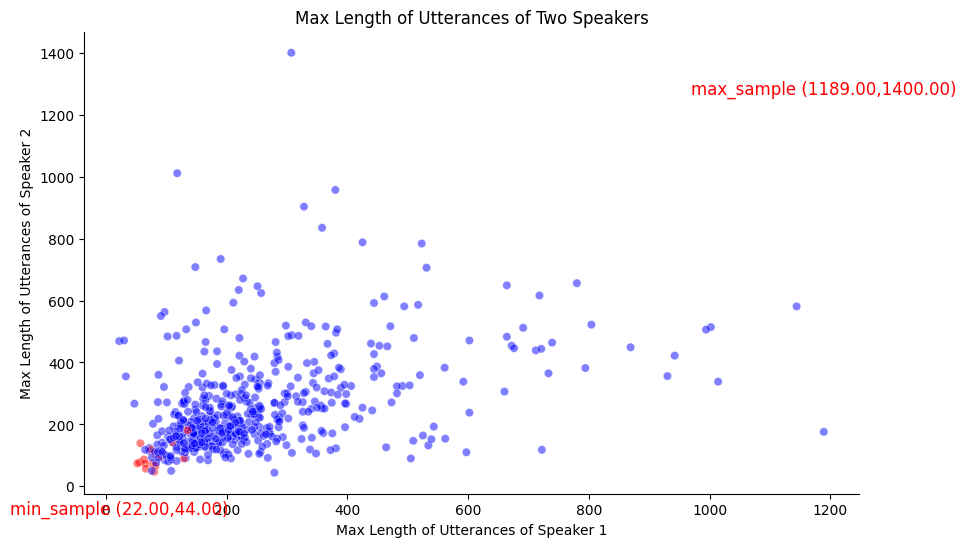

In [23]:
visualize_two_speaker_utterances_max_length(train_df)

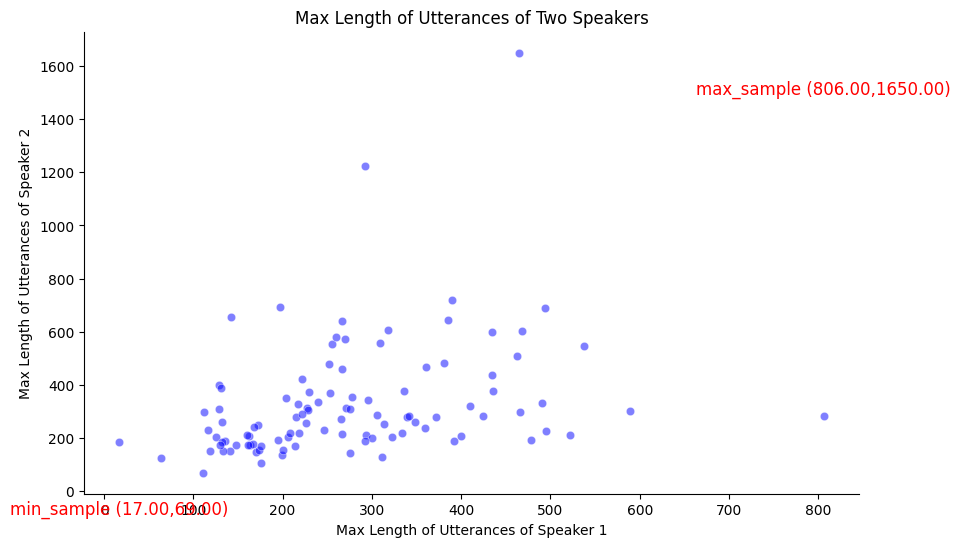

In [31]:
visualize_two_speaker_utterances_max_length(dev_df)

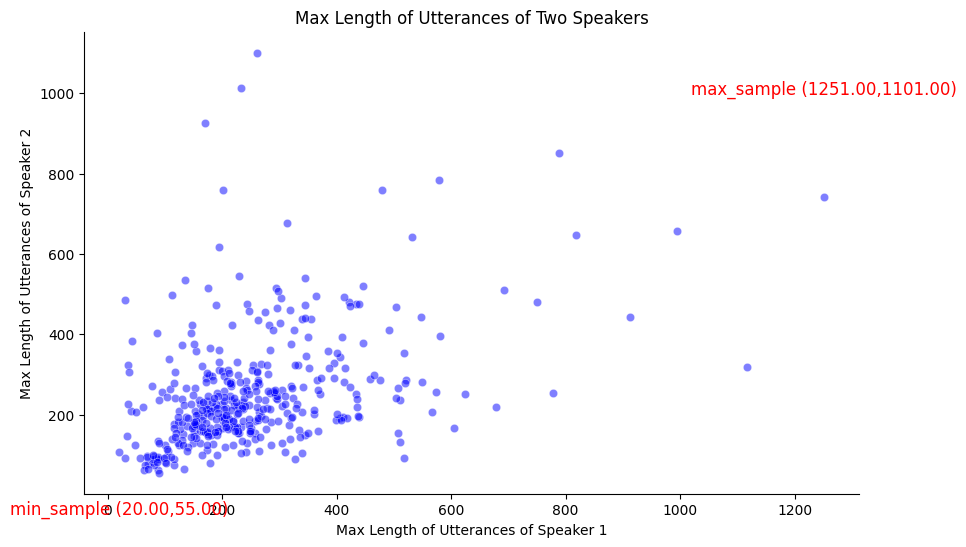

In [32]:
visualize_two_speaker_utterances_max_length(test_df)

## speaker_1의  개수가 50이상인 샘플을 추출 

In [42]:
train_df['speakers'].iloc[0][0]

'SD2000001'

In [49]:
# speaker_1의  개수가 50이상인 샘플을 추출 

def extract_speaker_1_num_over_50(df:pd.DataFrame) -> pd.DataFrame:
    """
    Extract samples where the number of utterances of speaker 1 is over 50.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.

    Returns:
    pd.DataFrame: Extracted DataFrame.
    """
    df = deepcopy(df)

    # Extract samples where the number of utterances of speaker 1 is over 50
    speaker_1_utterances_num = df.apply(lambda x: x['num_utterances_per_speaker'].get(x['speakers'][0], 0), axis=1)
    df = df[speaker_1_utterances_num >= 50]

    print(f"Number of samples where the number of utterances of speaker 1 is over 50: {len(df)}")

    return df

In [63]:
extract_speaker_1_num_over_50(train_df).index

Number of samples where the number of utterances of speaker 1 is over 50: 15


Index([6, 310, 311, 323, 324, 339, 349, 358, 359, 362, 413, 444, 460, 461,
       492],
      dtype='int64')

In [58]:
for turn in train_df['conversation'].iloc[460]:
    print(turn['utterance'] if turn['speaker']== train_df['speakers'].iloc[460][0] else None)

어제 던킨 갔다 왔잖아. 거기에 새로 나온 초코 도너츠가 있는데 그게 진짜 맛있더라고
None
초코 필링이 이렇게 딱 있고 다음에 위에 오레오 과자가 부서져서 이렇게 뿌려져 있더라고
None
너 만약 초코 좋아한다 그럼 진짜 무조건 먹어야 돼
None
마시멜로 올라가 있는 거 어제 샀는데 어제 초코가 너무 달아서 못 먹었어.
None
그렇지.
None
이번에 새로 나온 메뉴니까
None
그렇지.
None
나도 한 2천 원 넘을 줄 알고 고민했 고민하다가 갔거든 샐러드 사는 김에 근데 가격은 비슷하더라고 1900원?
None
샐러드는 아마 5천 원 중반 대였던 거 같아.
None
샐러디는 그냥 곧바로 나오니까
None
맞아.
None
응.
None
나는 네가 당연히 싫어 할 이상한 나라의 솜사탕
None
그래? 그거 이번에 새롭게 나왔더라고 또 리뉴얼 돼서
None
그래서 이따가 배라 사게 되면 먹어 보려고
None
근데 애들 체리쥬빌레 싫어하는 애들 진짜 많아.
None
레인보우 샤베트 새콤해서 맛있는데
None
싫어하는 근데 진짜 체리쥬빌레가 호불호가 진짜 많이 갈려
None
안에 있는 체리가 진짜 맛있어.
None
저는 녹차 싫어해서요.
None
녹차 먹금 입니다.
None
풀집 먹는 느낌이야.
None
그렇지. 어렸을 때 돌로 빻던 풀집 맛
None
그렇지 잡초
None
잠깐 민초와 치약을 동등시 여기는 것처럼 녹차와 잡초가 동등시 되는 거지.
None
잡초도 먹을 순 있어.
None
잡촌 먹을 수 있어.
None
아니 나 말고
None
난 진짜 극 불호
None
저와 함께 가실 수 없을 것 같네요.
None
근데 민초가 베라에서 1위더먼.
None
모순인데?
None
민초 맛 없어.
None
그냥 정말 가끔씩 이만큼 입이 텁텁하다 싶을 때만 맛있고 이걸 파인트 한 통 하프갤런 한 통 와 이건 진짜 아니야.
None
아니 아까 나 친구 만났잖아. 근데 이번에 할로윈 기념해서 베라에서 이달에 맛이 나온 거야.
초코 맛이랑 다음에 예전에 블랙 소르베 기억나?

In [59]:
train_df['output'].iloc[460]

'## 전반적인 요약\n두 화자는 이 대화에서 도넛, 아이스크림에 관한 대화를 했습니다.\n\n## SD2100566 요약\n- SD2100566은 어제 던킨에서 초콜릿 도넛을 먹었는데, 초콜릿 시럽과 과자가 올려져 있어서 맛있었다고 말했고, 가격이 비싸서 망설였지만 1900원 정도여서 샀다고 했습니다. \n- 그리고 베스킨라빈스에서 이상한 나라의 솜사탕을 제일 좋아한다고 말했고, 민트 초콜릿 맛은 싫어한다고 말했습니다. \n\n## SD2100565 요약\n- SD2100565는 던킨 도넛이 먹고 싶었지만, 가격이 부담되어서 참았다고 말했습니다. \n- 그리고 샐러디의 재료가 싱싱하고 입맛에 맞는 것 같다고 했습니다. \n- 또한 베스킨라빈스에서 아이스크림을 먹었는데, 엄마는 외계인을 가장 선호한다고 말했습니다. \n- 한편 민트 초콜릿이 가장 맛있는 맛과 맛없는 맛 둘 다 1위로 뽑혔다며, 본인은 먹을 만하다고 했습니다. '

In [44]:
extract_speaker_1_num_over_50(train_df)

,id,conversation,subject_keyword,speakers,output,num_utterances_per_speaker
